# **Digit Recognition**

DSC-440 Project 2

Brian Chaffee

---
**Description:**

Using the MNIST dataset adapted from the Kaggle Competition. The objective is to create a Convolutional Neural Network that successfuly is able to predict the correct digit from 0 to 9 from a list of handwritten digits. 

I will be utilizing data augmentation alongside the convoltutional neural network in order to better prevent overfitting the created model.

[Kaggle Link](https://www.kaggle.com/competitions/digit-recognizer/code?competitionId=3004&sortBy=voteCount&excludeNonAccessedDatasources=true)
- The only adaptation is using `tensorflow.keras.datasets` instead of the provided datasets.

## Imports
---

Utilizing the Keras package from Tensorflow due to the ease and intuitive aspects of creating the Neural Network 

In [1]:
# Imports
# # Basic Imports
import pandas as pd
import numpy as np

# # Machine Learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers


# # # Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # # Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# # Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dataset
---

Utilizing the tensorflow library to load in the dataset from it's built in `load_data` function

In [17]:
from tensorflow.keras.datasets import mnist

# Loading dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Look at a small sample of the images in the dataset to vizualize what the handwritten digit images look like 

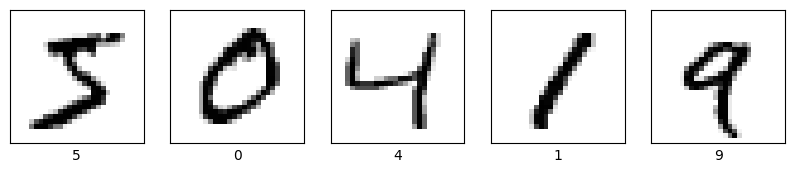

In [18]:
# Display example images
num_images = 5
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

Create a figure displaying the count of each digit to verify that they are equally distributed

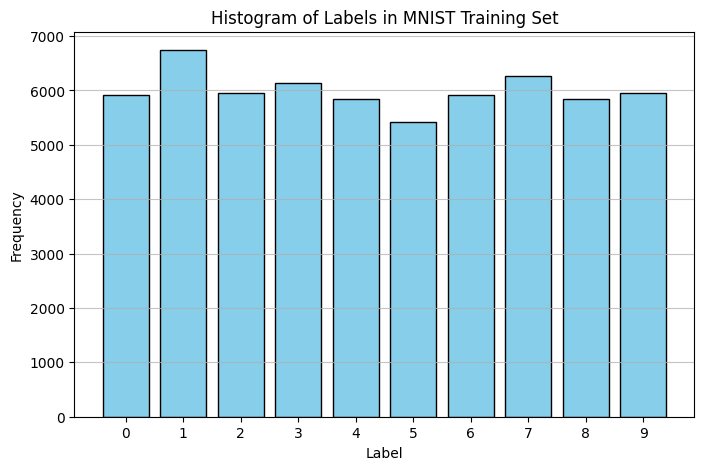

In [19]:
plt.figure(figsize=(8, 5))
plt.hist(y_train, bins=range(11), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Histogram of Labels in MNIST Training Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.grid(axis='y', alpha=0.75)
plt.show()

## Data Preprocessing
---

The data needs to be normalized and reshaped in order to fit within the CNN structure that Keras accepts

The shape of the training and testing sets help determine preprocessing methods in order to fit within the model. Here, the shape shows that there are 60000 training imagees and there are a 28 pixels that represent the height and width.

In [5]:
print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


### Normalizing

Normalizing the data basically grayscales the image and reduces the extra illumination around the edges. The data is divided by 255 because it reduces the color channels of the pixels and also reduces the effects that larger numbers may have on the model.

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Reshaping

The data also needs to be reshaped in order to be fit within a CNN model. The CNN requires an additional channel that represents the color of the image. Here it is represented as a one in order to describe the grayscale images.

In [7]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

## CNN
---

### Training and Validation Split
Creating the Convolutional Neural Network, the data needs to be split into training and testing (validation) sets. Here, 20 percent of the dataset is sectioned out in order to be used as a validation set for the model. 

*However, the dataset is already split into 60000 training points and 10000 testing points from the `load_data` package in keras.*

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)

### Data Augmentation

Data Augmentation is going to help reduce the possibility of overfitting the model by artifically increasing the amount of training data. Using the `ImageDataGenerator` from keras, a selection of changes are able to be input where the `X_train` data will be altered slightly when input into the model fitting.

The data is transformed slightly in order to simulate the variability in handwriting and increase the training set in order to reduce overfitting data. It is able to see multiple variations on the digits.

In [9]:
datagen = ImageDataGenerator(

    rotation_range = 15,        # rotate image randomly within range of 10 degrees
    width_shift_range = 0.1,    # shift image horizontally
    height_shift_range = 0.1,   # shift image vertically
    zoom_range = 0.1            # zooms image
)

datagen.fit(X_train)

The data could be flipped vertically and horizontally, however, some numbers like 6 and 9 look like each other when flipped

### Defining Model

The Sequential function allows adding one layer at a time starting at input and working in order till the output layer. (Using Sequential, it recommends having an intial input layer rather in specifying input shape within the first layer).

The model has an initial convolutional layer that takes 112 filters and uses a 7x7 kernel size in order to determine the features from the images based within that 7x7 gridspace. Following the intial layer, there is a max pooling layer that works to reduce the dimensionality while maintaining the same number of features. the layers are then passed through a dropout layer in order to remove 25% of the neurons randomly and help reduce overfitting. 

`Conv2D()` layer

`AveragePooling2D()` layer

`Flatten()` layer

`Dense()` layer

In [10]:
model = models.Sequential([

    layers.Input(shape=(28,28,1)),

    layers.Conv2D(112, kernel_size = (7, 7), activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout((0.25)),

    layers.Conv2D(49, kernel_size = (3, 3), activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.Conv2D(49, kernel_size = (3, 3), activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.MaxPooling2D((2, 2)),


    layers.Flatten(),

    layers.Dense(56, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.Dense(10, activation='softmax')
])

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Evaluating the Model
---

In [12]:
# Store altered variabels
epochs = 8
batch_size = 32

In [13]:
# Train the model
model_history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data = (X_test,y_test))

# Evaluate the model
#test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
#print('\nTest accuracy:', test_acc)

Epoch 1/8


/Users/brianchaffee/.pyenv/versions/3.10.4/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.7950 - loss: 0.7992 - val_accuracy: 0.9825 - val_loss: 0.1966
Epoch 2/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9587 - loss: 0.2748 - val_accuracy: 0.9875 - val_loss: 0.1608
Epoch 3/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.9656 - loss: 0.2353 - val_accuracy: 0.9854 - val_loss: 0.1601
Epoch 4/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9694 - loss: 0.2085 - val_accuracy: 0.9868 - val_loss: 0.1475
Epoch 5/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9716 - loss: 0.2009 - val_accuracy: 0.9842 - val_loss: 0.1555
Epoch 6/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.9719 - loss: 0.1918 - val_accuracy: 0.9879 - val_loss: 0.1340
Epoch 7/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9747 - loss: 0.1823 - val_accuracy: 0.9888 - val_loss: 0.1282
Epoch 8/8
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9755 - loss: 0.1745 - va

### Plotting Training and Testing Curves

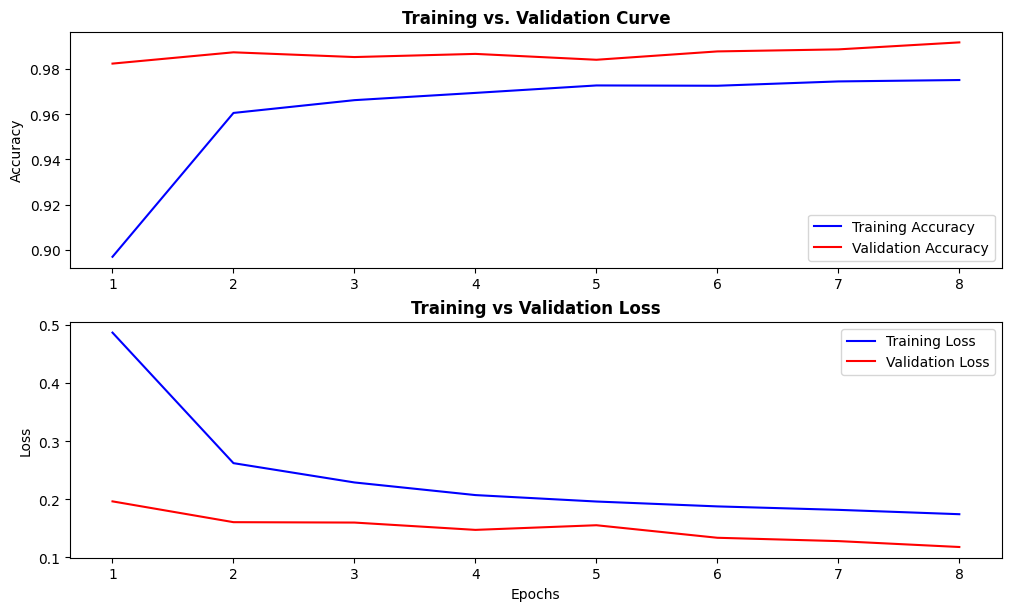

In [14]:
epoch_range = range(1, len(model_history.history['accuracy']) + 1)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), layout='constrained')
ax[0].plot(epoch_range, model_history.history['accuracy'], 'b-', label='Training Accuracy')
ax[0].plot(epoch_range, model_history.history['val_accuracy'], 'r-', label='Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training vs. Validation Curve', fontweight='bold')
ax[0].legend(loc='best')

ax[1].plot(epoch_range, model_history.history['loss'], 'b', label='Training Loss')
ax[1].plot(epoch_range, model_history.history['val_loss'], 'r', label='Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training vs Validation Loss', fontweight='bold')
ax[1].legend(loc='best')

plt.xlabel('Epochs')
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 2s - 6ms/step - accuracy: 0.9919 - loss: 0.1181

Test accuracy: 0.9919000267982483


### Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


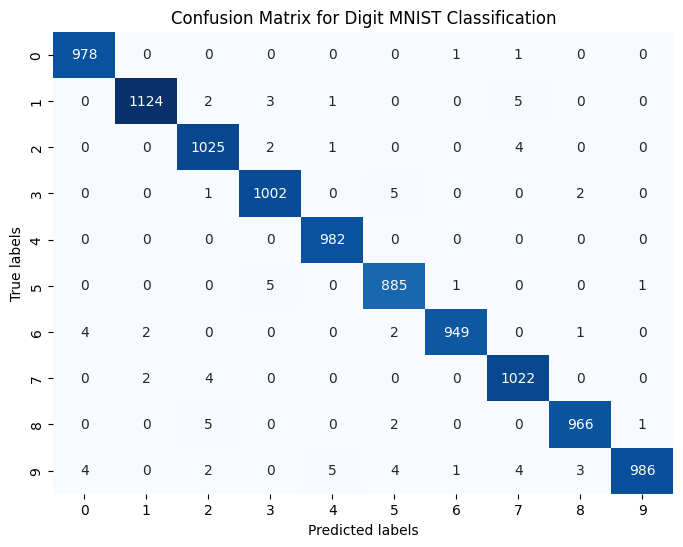

In [16]:
# Predict the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Digit MNIST Classification')
plt.show()

---
## Citations

1. LeCun, Y., Cortes, C., & Burges, C. J. (2010). MNIST handwritten digit database. ATT Labs [Online].  Available: Http://Yann. Lecun. Com/Exdb/Mnist, 2.